In [1]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
from pylab import *
from viewser.operations import fetch
from viewser import Queryset, Column
import glob

#some extra functions for some of the later demonstration
import pandas as pd
import numpy as np
import subprocess
#Define QuerySet
pd.set_option('display.max_rows', None)

In [2]:
queryset_base_PG = (Queryset("Benz_PG_CF", "priogrid_month")

    .with_column(Column("country_name", from_table = "country", from_column = "name")
        .transform.missing.replace_na()
        )
        
    .with_column(Column("year_id", from_table = "country_year", from_column = "year_id")
        )

    # target variable
    .with_column(Column("ged_sb", from_table = "ged2_pgm", from_column = "ged_sb_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )
        
    .with_column(Column("ged_ns", from_table = "ged2_pgm", from_column = "ged_ns_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("ged_os", from_table = "ged2_pgm", from_column = "ged_os_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("sb_count", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("ns_count", from_table = "ged2_pgm", from_column = "ged_ns_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("os_count", from_table = "ged2_pgm", from_column = "ged_os_best_count_nokgi")
        .transform.missing.replace_na()

        )
    .with_column(Column("pop_gpw_sum", from_table="priogrid_year", from_column="pop_gpw_sum")
        
        )
        )

In [3]:
queryset_base_CM = (Queryset("Benz_PG_CF", "country_month")

    .with_column(Column("country_name", from_table = "country", from_column = "name")
        .transform.missing.replace_na()
        )
        
    .with_column(Column("year_id", from_table = "country_year", from_column = "year_id")
        )

    # target variable
    .with_column(Column("ged_sb", from_table = "ged2_cm", from_column = "ged_sb_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )
        
    .with_column(Column("ged_ns", from_table = "ged2_cm", from_column = "ged_ns_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("ged_os", from_table = "ged2_cm", from_column = "ged_os_best_sum_nokgi")
        .transform.missing.replace_na()
        #.transform.ops.ln()
        )

    .with_column(Column("sb_count", from_table = "ged2_cm", from_column = "ged_sb_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("ns_count", from_table = "ged2_cm", from_column = "ged_ns_best_count_nokgi")
        .transform.missing.replace_na()

        )

    .with_column(Column("os_count", from_table = "ged2_cm", from_column = "ged_os_best_count_nokgi")
        .transform.missing.replace_na()

        )
    .with_column(Column("pop_gpw_sum", from_table="wdi_cy", from_column="wdi_sp_pop_totl")
        
        )
        )

In [4]:
#directories to set:
base_path = f'/Users/gbenz/Documents/Food Security and Conflict/'
source_PG_dir = '/Users/gbenz/Documents/Common Data/'

#### This toolbox considers 3 primary paramters

**Parameter 1:** Is this analysis employing PGM or CM data?<br><br>
**Parameter 2:** What level of SPACE aggregation is the user interested in?<br>
*Options include -- Original PrioGRid aggregation 1x1 or courser aggregations 2x2, 3x3, 4x4, 5x5, 6x6, 8x8, 9x9, and 10x10*<br><br>
**Parameter 3:** What level of TIME aggregation is the user interested in?<br><br>
*Options include -- Original PrioGRid monthly resolution and annual*<br>
Note that within this time parameter, the range of available data is fixed between 1989-2022.<br><br>
**Parameter 4:** Define the processing extent to apply space and time factors<br><br>
**Parameter 5:** Establish what statistics to generate for the Unit of Analysis and designated Area of Responsibility'<br><br>

In [5]:
def PGM_preprocess(table):

    #replace NA Population values with 0
    table['pop_gpw_sum'] = table['pop_gpw_sum'].replace({np.nan:0})

    #Locate NA values for the population field
    #df_109_516NA = df_109_516[df_109_516['pop_gpw_sum'].isna()] #this should come first
    #withNA = len(df_109_516NA)
    #print(f'length of NA df is expected to be 0 actual result is {withNA}')


    #df_109_516__HAS_POP = df_109_516[df_109_516['pop_gpw_sum'].notna()]
    #check1 = len(df_109_516__HAS_POP)
    #check2 = len(df_109_516)
    #print()
    #print(f'checking if the .notna() param is necessary -- is {check2} the same as {check1}?')
    #print('in the future could just use df_109_516 variable for proceeding code...')
    #df_110__HAS_POP = df_110[df_110['pop_gpw_sum'].notna()]

    table['Fatalities_Sum'] = table['ged_sb'] + table['ged_ns'] + table['ged_os']
    table['PerCapitaFatalities'] = table['Fatalities_Sum'] / table['pop_gpw_sum']
    table['PerCapitaFatalities'] = table['PerCapitaFatalities'].replace({np.nan:0})

    table = table.drop(['ged_sb','ged_ns','ged_os','sb_count','ns_count','os_count'], axis = 1)

    return(table)


In [6]:
def report_infinity_values(base_table,CM__or__PG, resolution=0):

    if resolution == 0:
        res = '_'
    else:
        res = resolution

    CM__or__PGstr = CM__or__PG+'_'

    base_table['PerCapitaFatalities'] = base_table['PerCapitaFatalities'].replace([np.inf, -np.inf], np.nan)
    Anamoly = base_table[base_table['PerCapitaFatalities'].isna()]
    Anamoly.to_csv(f'/Users/gbenz/Documents/Food Security and Conflict/{CM__or__PGstr}{res}Fatality_NoPop.csv')
    base_table['PerCapitaFatalities'] = base_table['PerCapitaFatalities'].replace({np.nan:0})

    return(base_table)

In [7]:
def PRIO_Aggregation(table,time,CMorPG,scale=0,country=0):
    
    import glob
        #1 -- create a dictionary for ID:Country
    #country_DICT = dict(zip(table['priogrid_gid'], table['country_name']))
    #PG_rows = table.loc[:, ['priogrid_gid']]
    
    #print(country_DICT)
    CM_or_PG = CMorPG
    c = np.isinf(table['PerCapitaFatalities']).values.sum() 
        #print("It contains " + str(c) + " infinite values") 
    if c > 0:    
        table=report_infinity_values(table,CM_or_PG)

    if time == 'monthly':
        time_attribute = 'month_id'
    elif time == 'annual':
        time_attribute = 'year_id'

    if scale == '1x1':
        #print('working on 1x1 here I only need to change the PRIO Grid ID column name')
        table = table.rename(columns={'priogrid_gid':'Scale_ID'})
        table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
        table = table.rename(columns={'country_name':'Included_Countries'})
        if country == 0:
            return(table)
        else:
            selected_country=table[table['Included_Countries'].isin([country])]
            return(selected_country)
        
    elif scale == 0:
        table = table.rename(columns={'country_id':'Scale_ID'})
        table = table.drop(['year_id', 'pop_gpw_sum'], axis=1)
        return(table) 
    #--------------------------------------------------
    else:
        #print('scale was not 1x1.. so doing something about that...')
        source_PG_aggregation_dir = '/Users/gbenz/Documents/Common Data/PG Aggregation/'
        allFiles = glob.glob(source_PG_aggregation_dir + "/*.csv")

        for filename in allFiles:
                if scale in filename:
                    print(filename)
                    break
        Aggregation_file = filename
        #print(Aggregation_file)

        single_res = int(scale.split('x')[0])

        Expected = single_res ** 2

        pg_AG = pd.read_csv(Aggregation_file)

        pg_AG['gid'] = pg_AG['gid'].astype(str)
        pg_AG['Id'] = pg_AG['Id'].astype(str)

        pg_AG['Scale_ID'] = pg_AG.groupby(['Id'])['gid'].transform(lambda x : '_'.join(x))

        pg_AG['gid'] = pg_AG['gid'].astype('int64')
        pg_AG['Id'] = pg_AG['Id'].astype('int64')
    #A method to get rows that communicate 1. Each indivdiual geospatial abstract id and corresponding PRIOgrid ID 
        pg_AG__FOR_VALIDATE = pg_AG.groupby(['Id','Scale_ID']).size().to_frame().iloc[:, :-1].reset_index()
        pg_AG__FOR_VALIDATE = pg_AG__FOR_VALIDATE.sort_values(by='Scale_ID')

        pg__AG = pg_AG.groupby('Scale_ID')['gid'].apply(list)
        pg__AG__dic = pg__AG.to_dict()

        table['Scale_ID'] = table.priogrid_gid.map({item: k for k, v in pg__AG__dic.items() for item in v})
        df_2022 = table.sort_values(by=['Scale_ID','priogrid_gid'], ascending=[False,True])

    #changes here --
        withcountry = df_2022.groupby(['Scale_ID','country_name']).size().to_frame().iloc[:, :-1].reset_index()
        withcountry['Country_present'] = withcountry.groupby(['Scale_ID'])['country_name'].transform(lambda x : '___'.join(x))
        withcountry = withcountry.drop(['country_name'], axis=1).drop_duplicates()
        withcountry__dic = dict(zip(withcountry.Scale_ID, withcountry.Country_present))
    #---------
        check = df_2022.groupby(['priogrid_gid','Scale_ID']).size().to_frame().iloc[:, :-1].reset_index()
        check = check.sort_values(by='Scale_ID')

        check_PGID = check.groupby(['Scale_ID']).size().to_frame().reset_index()
        check_PGID = check_PGID.rename(columns = {0:'Size'})
        check_PGID = check_PGID.sort_values(by='Size')
        less_than_expected = check_PGID[check_PGID['Size'] < Expected]
        print(less_than_expected)
        less_than_expected.to_csv('/Users/gbenz/Documents/Common Data/inf_FPC.csv')

        df_2022_grouped = df_2022.groupby([time_attribute,'Scale_ID']).agg({'PerCapitaFatalities':'sum','Fatalities_Sum':'sum'}).reset_index()

        if country == 0:
            return(df_2022_grouped)
        else:
            df_2022_grouped['Countries_In_AG_Unit']= df_2022_grouped['Scale_ID'].map(withcountry__dic)
            df_2022_grouped['Included_Countries'] = df_2022_grouped['Countries_In_AG_Unit'].str.split('___')
            selected_country = df_2022_grouped.loc[df_2022_grouped['Included_Countries'].explode().eq(country).loc[lambda x: x].index]
            selected_country = selected_country.drop('Included_Countries', axis=1)
            return(selected_country)

In [8]:
def report_length(data, PG_or_CM, scale, time, resolution):

    if scale == 'Individual':
        s = 'This individual'
    elif scale == 'Global':
        s = ' The global'

    if resolution == 0:
        res = ''
    else:
        res = 'and ' + resolution + ' resolution'

    if time == 'monthly':
        t = 'month_id'
    elif time == 'annual':
        t = 'year_id'

    events_df_2022 = len(data)
    PG_totalcells = len(pd.unique(data['Scale_ID']))
    PG_totalmonths = len(pd.unique(data[t])) 
    return(f'{s} {PG_or_CM} level {res} contains {events_df_2022} events.\nThis is calculated from {PG_totalcells} * {PG_totalmonths}')

In [9]:
def Format_summary_stats(PG_or_CM, table_to_describe,field_to_describe,zero__or__non_zero):
    
    if field_to_describe == 'Fatalities_Sum':
        SummaryField = 'Fatalities'

    elif field_to_describe == 'PerCapitaFatalities':
        SummaryField = 'Fatalities Per Capita'

    if zero__or__non_zero == 'zero' and PG_or_CM == 'PG':
        percentile = [.5,.7,.8,.85,.9,.95,.98,.99,.991,.992,.993,.994,.995,.996,.997,.998,.999,1]
        data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=percentile)})

    elif zero__or__non_zero == 'zero' and PG_or_CM == 'CM':
        percentile = [.5,.7,.8,.81,.82,.83,.84,.85,.86,.87,.88,.89,.9,.95,.98,.99,.991,.992,.993,.994,.995,.996,.997,.998,.999,1]
        data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=percentile)})

    elif zero__or__non_zero == 'non-zero':
        attribute_nozero=table_to_describe[table_to_describe[field_to_describe]!= 0]
        length_of_attribute_nozero = len(attribute_nozero)
        percentile = [0,.25,.5,.75,.8,.85,.9,.95,.99,.995,1]
        data = pd.DataFrame({SummaryField: attribute_nozero[field_to_describe].describe(percentiles=percentile)})

    #data = pd.DataFrame({SummaryField: table_to_describe[field_to_describe].describe(percentiles=percentile)})
    data = data.reset_index()
    data = data.rename(columns={'index':'Percentile'})
    data = data.iloc[4:][:-1]
    data['Percentile'] = data['Percentile'].str[:-1]

    if field_to_describe == 'Fatalities_Sum' and zero__or__non_zero == 'non-zero':
        data['Fatalities'] = (data['Fatalities']).astype(int)
        #attribute_nozero=table_to_describe[table_to_describe['Fatalities_Sum']!= 0]
        return(attribute_nozero, data, length_of_attribute_nozero)

    elif field_to_describe == 'Fatalities_Sum' and zero__or__non_zero == 'zero':
        data['Fatalities'] = (data['Fatalities']).astype(int)
        return(data)

    elif field_to_describe == 'PerCapitaFatalities' and zero__or__non_zero == 'non-zero':
        #attribute_nozero=table_to_describe[table_to_describe['PerCapitaFatalities']!= 0]
        return(attribute_nozero, data, length_of_attribute_nozero)

In [10]:
def correct_definition_df(definition_dataframe,original_dataframe,zero__or__nonzero,single_cell_analysis,PG__or__CM='PG',single_cell_analysis_percentiles=[99,95]):

    check_list = list(definition_dataframe)

    if 'Fatalities' in check_list:
        #attribute_nozero=original_dataframe[original_dataframe['Fatalities_Sum']!= 0]
        #return(Fatalities_nozero)
        if PG__or__CM == 'CM':
            sub_perc = ['84','90','95','99','99.5','100']
            definition_dataframe['Percentile'] = definition_dataframe['Percentile'].astype('string')
            from_sub_perc = definition_dataframe[definition_dataframe['Percentile'].isin(sub_perc)]
            #from_sub_perc = definition_dataframe[definition_dataframe['Percentile'] in sub_perc]
            #match_p = definition_dataframe.loc[definition_dataframe['Percentile'] == i]
            def_values = from_sub_perc['Fatalities'].unique()
        else:
            def_values = definition_dataframe['Fatalities'].unique()
        id_fatality = []
        id_triggers = []
        id_p = []
            
    if 'Fatalities Per Capita' in check_list:
        #put here because some PCF were still 0 when filter was applied i
        #attribute_nozero=original_dataframe[original_dataframe['PerCapitaFatalities']!= 0]

        def_values = definition_dataframe['Fatalities Per Capita'].unique()
        id_percapita = []
        id_triggers = []
        id_p = []

    collected = pd.DataFrame()

    if single_cell_analysis == 'Yes':
        def_values = single_cell_analysis_percentiles

    for i in def_values:
                            if 'Fatalities' in check_list and i == 0.0:
                                #if i == 0.0:
                                continue
                            elif 'Fatalities' in check_list and i != 0.0:
                                match_p = definition_dataframe.loc[definition_dataframe['Fatalities'] == i]
                                perc = match_p.at[match_p.index[0], 'Percentile']
                                limit = original_dataframe.loc[original_dataframe['Fatalities_Sum'] >= i]
                                triggers = len(limit.index)
                                fatality = i

                                id_p.append(perc)
                                id_fatality.append(fatality)
                                id_triggers.append(triggers)

                                Out_Percentile = pd.DataFrame(list(zip(id_p, id_fatality, id_triggers)),
                                    columns=['Percentile','Fatalities','Occurance'])
                                
                            if 'Fatalities Per Capita' in check_list:
                                match_p = definition_dataframe.loc[definition_dataframe['Fatalities Per Capita'] == i]
                                perc = match_p.at[match_p.index[0], 'Percentile']
                                limit = original_dataframe.loc[original_dataframe['PerCapitaFatalities'] >= i]
                                triggers = len(limit.index)
                                capita = i                        

                                id_p.append(perc)
                                id_percapita.append(capita)
                                id_triggers.append(triggers)

                                Out_Percentile = pd.DataFrame(list(zip(id_p, id_percapita, id_triggers)),
                                    columns=['Percentile','Fatalities Per Capita','Occurance'])
                            
    if zero__or__nonzero == 'zero' or single_cell_analysis == 'Yes':
           
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        return(collected)
    
    elif zero__or__nonzero == 'non-zero'and 'Fatalities Per Capita' in check_list:
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        collected['Fatalities Per Capita'] = collected['Fatalities Per Capita']*10000
        collected['Fatalities Per Capita'] = collected['Fatalities Per Capita'].round(1)
        collected = collected.rename(columns={'Fatalities Per Capita':'Per Capita'})
        Transpose_desc=collected.transpose()
        new_header = Transpose_desc.iloc[0] #grab the first row for the header
        Transpose_desc_less = Transpose_desc[1:] #take the data less the header row
        Transpose_desc_less.columns = new_header
        Transpose_desc_less = Transpose_desc_less.reset_index()
        Transpose_desc_less = Transpose_desc_less.rename(columns={'index':'Percentile'})

        return(Transpose_desc_less)

    elif zero__or__nonzero == 'non-zero' and 'Fatalities' in check_list:
        collected = pd.concat([collected, Out_Percentile], ignore_index=True) 
        Transpose_desc=collected.transpose()
        new_header = Transpose_desc.iloc[0] #grab the first row for the header
        Transpose_desc_less = Transpose_desc[1:] #take the data less the header row
        Transpose_desc_less.columns = new_header
        Transpose_desc_less = Transpose_desc_less.reset_index()
        Transpose_desc_less = Transpose_desc_less.rename(columns={'index':'Percentile'})

        return(Transpose_desc_less)

    #elif zero__or__nonzero != 'zero' or zero__or__nonzero != 'non-zero':
        #print('This parameter was incorrectly named. Select from zero or non-zero') 

In [11]:
def params_for_graphs(description,original_df,a,b,c,):

    a=str(a)
    b=str(b)
    c=str(c)

    desc_attribute = description.at[0, 'Percentile']
    if desc_attribute == 'Fatalities':
        attribute = 'Fatalities_Sum'
    elif desc_attribute == 'Fatalities Per Capita':
        attribute = 'PerCapitaFatalities'

    f_fpc=original_df[attribute]
    #fpc=df_109_516___Fatalities['PerCapitaFatalities']

    #print('trying to now select 85th percentile value')
    Select_a_Percentile = description.at[0,a]
    Select_b_Percentile = description.at[0,b]
    Select_c_Percentile = description.at[0,c]

#print(Select_95_Percentile)

#print()
    Fatalities_a = f_fpc[f_fpc <= Select_a_Percentile]
    Fatalities_a_b = f_fpc[(f_fpc > Select_a_Percentile) & (f_fpc <= Select_b_Percentile)]
    Fatalities_b_c = f_fpc[(f_fpc > Select_b_Percentile) & (f_fpc <= Select_c_Percentile)]
    Fatalities_c = f_fpc[(f_fpc > Select_c_Percentile)]

    Fatalities_a = np.sort(Fatalities_a)
    cdf_a = 1.0 * np.arange(len(Fatalities_a)) / float(len(Fatalities_a) - 1)
    Fatalities_a_b = np.sort(Fatalities_a_b)
    cdf_a_b = 1.0 * np.arange(len(Fatalities_a_b)) / float(len(Fatalities_a_b) - 1)
    Fatalities_b_c = np.sort(Fatalities_b_c)
    cdf_b_c = 1.0 * np.arange(len(Fatalities_b_c)) / float(len(Fatalities_b_c) - 1)
    Fatalities_c = np.sort(Fatalities_c)
    cdf_c = 1.0 * np.arange(len(Fatalities_c)) / float(len(Fatalities_c) - 1)
    return((Fatalities_a,cdf_a), (Fatalities_a_b,cdf_a_b), (Fatalities_b_c,cdf_b_c), (Fatalities_c,cdf_c))

In [12]:

def ax4_params(resolution):

    if resolution == '2x2':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 50
        ax4_set_xticks = (0,10,20,30,40,50)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)

    elif resolution == '3x3':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 60
        ax4_set_xticks = (0,15,30,45,60)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)

    elif resolution == '4x4':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 75
        ax4_set_xticks = (0,15,30,45,60,75)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)
    
def ax6_params(resolution):

    if resolution == '2x2':
        ax6_set_xticks = [50,75,100,125,155]
        ax6_set_xticks_labels = ['0',' ','100','','155']
        ax6_set_yticks = [0,50,100,150,200]
        ax6_set_yticks_labels = ['0',' ','100','','200']
        return(ax6_set_xticks, ax6_set_xticks_labels, ax6_set_yticks, ax6_set_yticks_labels)

    elif resolution == '3x3':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 60
        ax4_set_xticks = (0,15,30,45,60)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)

    elif resolution == '4x4':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 75
        ax4_set_xticks = (0,15,30,45,60,75)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)
    
def ax8_params(resolution):

    if resolution == '2x2':

        ax8_set_xticks = (150,250,500,750,1050)
        ax8_set_xticks_labels = ['150',' ','500','750','1050']
        ax8_set_yticks = [0,25,50,75,100]
        ax8_set_yticks_labels = ['0',' ','50','','100']
        return(ax8_set_xticks, ax8_set_xticks_labels, ax8_set_yticks, ax8_set_yticks_labels)

    elif resolution == '3x3':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 60
        ax4_set_xticks = (0,15,30,45,60)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)

    elif resolution == '4x4':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 75
        ax4_set_xticks = (0,15,30,45,60,75)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)
    
def ax10_params(resolution):

    if resolution == '2x2':
        ax10_set_xticks = (1050,25000,50000,100000,200000)
        ax10_set_xticks_labels = ['1050',' ','50000','100000','200000']
        ax10_set_yticks = [0,5,10]
        ax10_set_yticks_labels = ['0','5','10']
        ylim = 10
        return(ax10_set_xticks, ax10_set_xticks_labels, ax10_set_yticks, ax10_set_yticks_labels, ylim)

    elif resolution == '3x3':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 60
        ax4_set_xticks = (0,15,30,45,60)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)

    elif resolution == '4x4':
        ax4_set_ylim_max = 2000
        ax4_set_xlim_max = 75
        ax4_set_xticks = (0,15,30,45,60,75)
        return(ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks)

In [13]:
def annotate_axes(ax, text, fontsize=18):
        ax.text(0.5, 0.5, text, transform=ax.transAxes,
                ha="center", va="center", fontsize=fontsize, color="darkgrey")

    #def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeseries):    
def statsheet(zerotable, nonzerotable_Fatality, nonzerotable_fpc, hist1, cdf1, hist2, cdf2, hist3, cdf3, hist4, cdf4, timeline, resolution=0):    

    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita']*10000
    #nonzerotable_fpc['Fatalities Per Capita'] = nonzerotable_fpc['Fatalities Per Capita'].round(1)

    #if resolution != 0:
    res = resolution

    #For timeline--------------------------v
    timeline_month_fatalitytotal = timeline.groupby(["month_id"]).Fatalities_Sum.sum().reset_index().reset_index()

    timeline_month_fatalities20000 = timeline_month_fatalitytotal.loc[timeline_month_fatalitytotal['Fatalities_Sum']>20000]

    index_to_color = timeline_month_fatalities20000['index']
    #--------------------------------------^

    units_of_analysis = '13000'
    percent_zero_fromtable = '99.3%'
    percent_nonzero_fromtable ='.6%'
    total_nonzero_fromtable = '1300'
    inf_total = '7'
    MissingData1 ='Y# occurances of 2 or less# fatalities and Y# occurances of 3-5 fatalities.'
    MissingData2 = 'Y# counts of fatalities between n and n'
    MissingData3 = 'XXXXXXX# fatalities were recorded between XX and XX of XXXX, XXXXXX in XX-XX, XXXXXXXX# in XX-XX, and XXXXX# in XX-XX'
    inputtext = 'In this text I want to summarize:\nalso, the per capita row reflects 1/10,000 individuals 1. The definition of event in this iteration 2.The total number of Events.\n Including how many months and the month ranges. Describe the graphs \n why do the total fatalities not match the total PCF (becuse 7 events in area with no population\n This is the last line that you have room for!'
    inputtext = f'Defining an event, summarizing fatalities, as a 1x1 standard PRIO Grid across a monthly temporal resolution produced {units_of_analysis} units of analysis. Summary tables\n discriminate between events reflecting zero and non-zero fatality results. At the employed unit scale, zero fatalities account for {percent_zero_fromtable} of all events. The remaining\n tables and graphics are constituent to that remaining {percent_nonzero_fromtable} ({total_nonzero_fromtable}) fatalities. Non-zero results from the Per Capita table reflect a unique total from the reported fatalities,\n {inf_total} events contained fatalities in units with no expected population values. Several graphics host data that is not completely visualized with extreme values exceeding\n the Y-axis; These locations are indicated by a prominent red bar. The following relationships uncover the obscured information. 1st-85th Percentile: There were\n {MissingData1} ; 99.5-100th Percentile: {MissingData2}'
    
    fig = plt.figure(figsize=(11, 8.5), constrained_layout = True)
    spec = fig.add_gridspec(7, 4)

#Zero table
    ax0 = fig.add_subplot(spec[0:3, :-3])
    annotate_axes(ax0, 'ax0')
    table_ax0 = ax0.table(cellText=zerotable.values,
                    colLabels=zerotable.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    #table_ax0.auto_set_font_size(True)
    table_ax0.set_fontsize(8)
    ax0.axis('off')
    table_ax0.scale(1, 1.65)

# Summary Text
    ax1 = fig.add_subplot(spec[0, -3:])
    #annotate_axes(ax1, 'ax1')
    ax1.text(0, 0.5,inputtext, fontsize=6, va='top',wrap='True',
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    ax1.axis('off')
    ax1.set_title('Global 1x1, monthly Stat Sheet')

    #ax1.margins(x=-.25)
    #text_ax1.scale(-.25, 1)

#plt.text(5, 5, input_text, fontsize=10, style='oblique', ha='center', va='top', wrap=True, rotation=-30)

#Non-Zero Fatalities
    ax2 = fig.add_subplot(spec[1, -3:])
    #annotate_axes(ax1, 'ax1')
    table_ax2 = ax2.table(cellText=nonzerotable_fpc.values,
                    colLabels=nonzerotable_fpc.columns,
                    loc='center',
                    cellLoc='center',
                    rowLoc='center')
    table_ax2.auto_set_font_size(False)
    table_ax2.set_fontsize(6)
    ax2.axis('off')
    table_ax2.scale(1.0, 1.85)

#Non-Zero Fatalities
    ax3 = fig.add_subplot(spec[2, -3:])

    cellcolours_array = [['#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9','#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33',],
                        ['#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fef0d9', '#fdcc8a', '#fdcc8a', '#fc8d59', '#fc8d59', '#e34a33']]

    table_ax3 = ax3.table(cellText=nonzerotable_Fatality.values,
                    colLabels=nonzerotable_Fatality.columns,
                    cellColours=cellcolours_array,
                    loc='top',
                    cellLoc='center',
                    rowLoc='center')
    table_ax3.auto_set_font_size(False)
    table_ax3.set_fontsize(6)
    ax3.axis('off')
    table_ax3.scale(1, 1.85)

    ax4_set_ylim_max,ax4_set_xlim_max,ax4_set_xticks = ax4_params(res)

    #Histogram 1-85
    ax4 = fig.add_subplot(spec[3, 0])
    annotate_axes(ax4, 'ax4')
    N, bins, patches_ax4 = ax4.hist(hist1, bins=100, color='black')
    ax4.set_title("1-85th Percentile")
    for i in range(0,10):
        patches_ax4[i].set_facecolor('red')
    #ax4.set_xlabel("Fatalities")
    ax4.set_ylabel("Count of Fatalities")
    ax4.set_ylim(0, ax4_set_ylim_max)
    ax4.set_xlim(0, ax4_set_xlim_max)
    ax4.set_xticks(ax4_set_xticks)
    #ax4.set_yticks((0,500,1000,1500,2000))
    ax4.set_yticks(ticks=[0,500,1000,1500,2000],labels=['0',' ','1000','','2000'])

    for label in ax4.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax4.tick_params(axis='x', labelcolor='white', labelsize=.1)
    ax4.set_facecolor('#fef0d9')

    #CDF 1-85
    ax5 = fig.add_subplot(spec[4, 0])
    annotate_axes(ax5, 'ax5')
    ax5.plot(hist1, cdf1, color='black')
    ax5.set_xlabel("Fatalities")
    ax5.set_ylabel("Probability")
    ax5.set_title("CDF (1-85)")
    ax5.sharex(ax4)
    ax5.set_xticks(ax4_set_xticks)
    #ax5.set_yticks((0,50,100,200,225))

    for label in ax5.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax5.xaxis.label.set_color('black')
    ax5.set_facecolor('#fef0d9')
    
    ax6_set_xticks, ax6_set_xticks_labels, ax6_set_yticks, ax6_set_yticks_labels = ax6_params(res)

    #Histogram 85-95
    ax6 = fig.add_subplot(spec[3, 1])
    annotate_axes(ax6, 'ax6')
    ax6.hist(hist2, bins=100, color='black')
    ax6.set_title("85-95th Percentile")
    ax6.tick_params(axis='x', labelcolor='white')
    ax6.set_xticks(ticks=ax6_set_xticks, labels=ax6_set_xticks_labels)
    #for label in ax6.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax6.set_yticks(ticks=ax6_set_yticks,labels=ax6_set_yticks_labels)
    ax6.set_facecolor('#fdcc8a')

    #Histogram 85-95
    ax7 = fig.add_subplot(spec[4, 1])
    annotate_axes(ax7, 'ax7')
    ax7.plot(hist2, cdf2, color='black')
    ax7.set_title("CDF (85-95)")
    ax7.sharex(ax6)
    #for label in ax7.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax7.set_facecolor('#fdcc8a')

    ax8_set_xticks, ax8_set_xticks_labels, ax8_set_yticks, ax8_set_yticks_labels = ax8_params(res)

    #Histogram 95-99.5
    ax8 = fig.add_subplot(spec[3, 2])
    annotate_axes(ax8, 'ax8')
    ax8.hist(hist3, bins=100, color='black')
    ax8.set_title("95-99.5 Percentile")
    ax8.tick_params(axis='x', labelcolor='white')
    ax8.set_xticks(ticks=ax8_set_xticks, labels=ax8_set_xticks_labels)
    #for label in ax8.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax8.set_yticks(ticks=ax8_set_yticks,labels=ax8_set_yticks_labels)
    ax8.set_facecolor('#fc8d59')

    #CDF 95-99.5
    ax9 = fig.add_subplot(spec[4, 2])
    annotate_axes(ax9, 'ax9')
    ax9.plot(hist3, cdf3, color = 'black')
    ax9.set_title("CDF (95-99.5)")
    ax9.sharex(ax8)
    #ax9.set_xticks((125,200,300,400,500,600,700,800),)
    #for label in ax9.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax9.set_facecolor('#fc8d59')

    ax10_set_xticks, ax10_set_xticks_labels, ax10_set_yticks, ax10_set_yticks_labels, ylim = ax10_params(res)

    #Histogram 99.5-100
    ax10 = fig.add_subplot(spec[3, 3])
    annotate_axes(ax10, 'ax10')
    N, bins, patches_ax10=ax10.hist(hist4, bins=100, color='black')
    ax10.set_title("99.5-100th Percentile")
    ax10.tick_params(axis='x', labelcolor='white')
    ax10.set_ylim(0, ylim)
    ax10.set_xticks(ticks=ax10_set_xticks, labels=ax10_set_xticks_labels)
    ax10.set_yticks(ticks=ax10_set_yticks,labels=ax10_set_yticks_labels)
    #for i in range(0,2):
    #    patches_ax10[i].set_edgecolor('white')
    #    patches_ax10[i].set_facecolor('red')

    #for label in ax10.xaxis.get_ticklabels()[::1]:
    #    label.set_visible(False)
    ax10.set_facecolor('#e34a33')

    #CDF 99.5-100
    ax11 = fig.add_subplot(spec[4, 3])
    annotate_axes(ax11, 'ax11')
    ax11.plot(hist4, cdf4, color = 'black')
    ax11.set_title("CDF (99.5-100)")
    ax11.sharex(ax10)
    #ax11.set_xticks((10000,50000,100000,150000))
    #for label in ax11.xaxis.get_ticklabels()[::2]:
    #    label.set_visible(False)
    ax11.tick_params(axis='x', labelsize=7)

    ax11.set_facecolor('#e34a33')


    ax12 = fig.add_subplot(spec[5:, :])
    annotate_axes(ax12, 'ax12')
    bars=ax12.bar(timeline_month_fatalitytotal['month_id'],timeline_month_fatalitytotal['Fatalities_Sum'],align='center', color = 'darkgrey') # A bar chart
    ax12.set_xlabel('Month')
    ax12.set_ylabel('Total Fatalities')
    ax12.set_ylim(0, 18500)
    for col in index_to_color:
        # That's it!
        bars[col].set_color('white')
    
    #ax7 = fig.add_subplot(spec[4, 1])
    #ax.get_yaxis().set_label_coords(-0.1,0.5)

    fig.align_ylabels()

    #fig.tight_layout()
    return(plt.show())


In [14]:

def Graph_it_all (PG_or_CM, monthly_or_annual, resolution=0, country=0):

    pg__or__cm = PG_or_CM
    res = resolution
    cntry = country
    
    if PG_or_CM == 'PG':
        df_pg = queryset_base_PG.publish().fetch()
    #Reset index in order to access 'month_id' and 'priogrid_gid' columns
        df_pg = df_pg.reset_index()
        df_109_516 = df_pg.loc[(df_pg['month_id']>=109) & (df_pg['month_id']<= 516)]

    else:
        df_cm = queryset_base_CM.publish().fetch()
        df_cm = df_cm.reset_index()
        df_109_516 = df_cm.loc[(df_cm['month_id']>=109) & (df_cm['month_id']<= 516)]

    df__PP=PGM_preprocess(df_109_516)
    df_ag=PRIO_Aggregation(df__PP, monthly_or_annual,pg__or__cm, resolution, cntry)

    printed_introduction = report_length(df_ag, PG_or_CM,'Global', monthly_or_annual,resolution)
    print(printed_introduction)

    format_fatalities_zero=Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','zero')
    print(format_fatalities_zero.dtypes)
    
    described_fatalities_zero = correct_definition_df(format_fatalities_zero,df_ag,'zero','No',pg__or__cm)

    fatalities_nonzero, described_fatalities_nonzero,len_fat = Format_summary_stats(PG_or_CM,df_ag,'Fatalities_Sum','non-zero')
    Fatalities_nonzero_cordef = correct_definition_df(described_fatalities_nonzero, fatalities_nonzero,'non-zero','No')
    print(len_fat)
    
    pcf_nonzero, described_pcf_nonzero, len_fpc = Format_summary_stats(PG_or_CM,df_ag,'PerCapitaFatalities','non-zero')
    pcf_nonzero_cordef = correct_definition_df(described_pcf_nonzero, pcf_nonzero,'non-zero','No')
    print(len_fpc)
    a, b, c, d=params_for_graphs(Fatalities_nonzero_cordef,fatalities_nonzero,85,95,99.5)

    print('type of A:')
    a_dic = a[0]
    a_cdf = a[1]
    b_dic = b[0]
    b_cdf = b[1]
    c_dic = c[0]
    c_cdf = c[1]
    d_dic = d[0]
    d_cdf = d[1]

    x = statsheet(described_fatalities_zero, Fatalities_nonzero_cordef, pcf_nonzero_cordef, a_dic, a_cdf, b_dic, b_cdf, c_dic, c_cdf, d_dic, d_cdf, fatalities_nonzero, res)    
    return(x)


 .    

/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_51928/2152826302.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['pop_gpw_sum'] = table['pop_gpw_sum'].replace({np.nan:0})
/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_51928/2152826302.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['Fatalities_Sum'] = table['ged_sb'] + table['ged_ns'] + table['ged_os']
/var/folders/1w/33c1s5gx5bq1358nxn0pmzlw0000gn/T/ipykernel_51928/2152826302.py:21: SettingWithCopyWarning: 
A val

/Users/gbenz/Documents/Common Data/PG Aggregation/PGM2x2.csv
                         Scale_ID  Size
1932  160165_160166_160885_160886     1
92    104119_104120_104839_104840     1
3027  183347_183348_184067_184068     1
1693  154519_154520_155239_155240     1
3034  183361_183362_184081_184082     1
2284  166033_166034_166753_166754     1
2064  161717_161718_162437_162438     1
707   131491_131492_132211_132212     1
3060  184795_184796_185515_185516     1
3240      91109_91110_91829_91830     1
3080  186211_186212_186931_186932     1
3081  186213_186214_186933_186934     1
2307  167371_167372_168091_168092     1
1709  154553_154554_155273_155274     1
3084  187611_187612_188331_188332     1
1487  150221_150222_150941_150942     1
1488  151511_151512_152231_152232     1
2719  174659_174660_175379_175380     1
1490  151515_151516_152235_152236     1
1491  151525_151526_152245_152246     1
3365      96937_96938_97657_97658     1
3103  187649_187650_188369_188370     1
3116  189077_189078

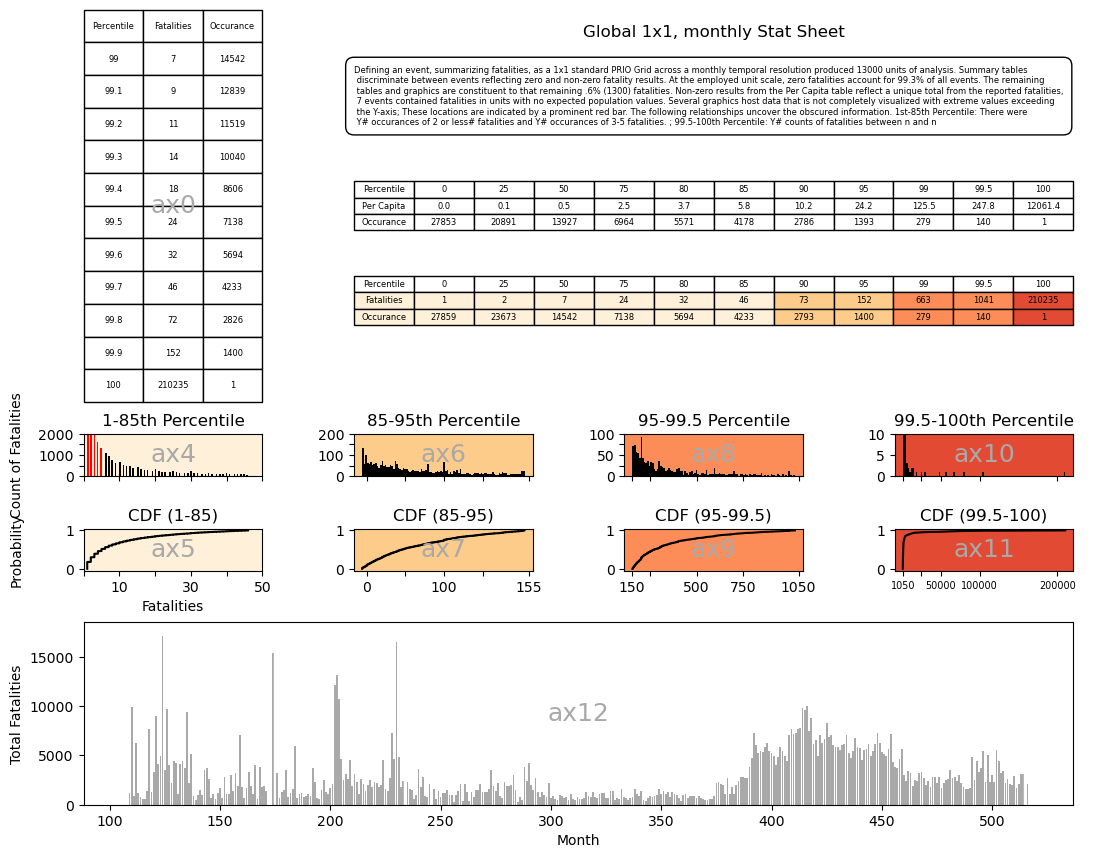

In [20]:
success = Graph_it_all('PG', 'monthly', '2x2', 'Ethiopia')